# Channel Routing Tutorial

In this notebook, we'll cover the basics routing hillslope discharge time series through a channel network. To learn more about how to simulate hillslope discharge, see the [hillslope discharge tutorial notebook](hillslope_discharge.ipynb). To learn more about how to create a channel network topoolgy and geometry from a digital elevation map, check out the [GRASS GIS tutorial]().

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import pickle
from datetime import date
import pandas as pd

We'll first need to import some classes to populate the hillslopes and channels of our REWs. The modules that are imported here must include all vadose zone, groundwater zone, and channel models that are specified in the `group_params` data strcuture discussed below. 

In [2]:
import sys
from os.path import dirname
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))

from channel import SimpleChannel

First, we'll need to set up some data structures to hold REW parameters and forcing data. We'll assume that these have already been computed and have been stored in the `model_data` subfolder of the parent folder. We'll then need to set some model parameters related to timescales and simuluation domains. These are both very similar to the set up in the [hillslope discharge tutorial notebook](hillslope_discharge.ipynb), and so we won't go into too much detail here. It's worth noting that we specify different timescales for hillslope discharge and channel routing. This provides us the flexibility to dial down the channel routing time step in order to ensure numerical convergence of the kinematic wave solver, while at the same time not requiring the relatively simpler hillslope discharge solver to operate at this short time step.

In [3]:
hill_groups = pickle.load( open( os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'), "rb" ) )
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
rew_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','rew_forcing.p'), "rb" ) )
channel_params = pickle.load( open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ))

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_channel']
t = model_config['t_channel']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
timestamps_hillslope = model_config['timestamps_hillslope']
timestamps_channel = model_config['timestamps_channel']

The `channel_params` file must contain a dictionary whose keys are REW IDs, and whose values are themselves dictionaries. These key-value pairs of these inner dictionaries the attribute names and values required to fully populate the user-specified `Channel` class.

In [4]:
channel_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(channel_params[rew_id])
    channel_network[rew_id] = SimpleChannel(rew_id=rew_id, **args)

We need to compute each channels discharge time series, starting from the headwaters and moving downstream. There are many ways we might compute an acceptable ordering of channels, but Grass GIS has already computed one for us; the Shreve index of a stream is defined as 1 if the stream is at the headwaters as the sum of its parents' Shreve indices otherwise. We can therefore simply compute channel flow starting with all channels with Shreve index 1 and work our way forward. 

The workhorse function in channel routing is the `update` method required by any inheritor of the abstract `Channel` class. As in solving any PDE, there is always the risk of introducing numerical instability in this update method if the time step is not sufficiently small. In this example, we have included a simple proof of concept testing procedure that raises a flag if the channel would be completely evacuated in a single timestep given the current velocity.

We save discharge data as a dictionary whose keys are REW IDs and whose values are time series; this file is placed in `network_volumetric_discharges` in the `model_data` folder. 


In [5]:
network_volumetric_discharges = {}
network_volumes = {}

rew_ids = rew_config.keys()
shreves = [rew_config[rew_id]['shreve'] for rew_id in rew_ids]

channelQueue = [rew_id for (shreve,rew_id) in sorted(zip(shreves,rew_ids))]

print(channelQueue)

for rew_id in channelQueue:
    shreve  = rew_config[rew_id]['shreve']
    group_id = rew_config[rew_id]['group']
    ppt = np.array(rew_forcing[rew_id][start_date:stop_date].ppt.resample(resample_freq_channel).ffill())
    hillslope_discharge = pd.DataFrame({'discharge':hill_groups[group_id]['discharge']}, index=hill_groups[group_id].index)
    hillslope_volumetric_discharge = np.array(hillslope_discharge[start_date:stop_date].discharge.resample(resample_freq_channel).ffill())*rew_config[rew_id]['upstream_area']
    volumetric_discharge = np.zeros(np.size(t))
    volumes = np.zeros(np.size(t))
    approx = 0
    
    if shreve == 1:
        up = np.zeros(np.shape(t))
    else:
        upstream_1 = rew_config[rew_id]['prev_str01']
        upstream_2 = rew_config[rew_id]['prev_str01']
        
        vol_1 = network_volumetric_discharges[upstream_1].volumetric_discharge.resample(resample_freq_channel).ffill()
        vol_2 = network_volumetric_discharges[upstream_2].volumetric_discharge.resample(resample_freq_channel).ffill()
        
        up = np.array(vol_1 + vol_2)
    
    for i in range(len(t)):
        result = channel_network[rew_id].update(dt, upstream_volumetric_discharge=up[i], hillslope_volumetric_discharge=hillslope_volumetric_discharge[i] , ppt=ppt[i])
        approx = (approx or result)
        volumetric_discharge[i]=channel_network[rew_id].volumetric_discharge
        volumes[i] = channel_network[rew_id].volume

    if approx==1: 
        print '\nWarning: Numerical instability encountered. Consider decreasing timestep size. \nDischarge for REW ' + str(rew_id) + ' had to be approximated for some timesteps. \n'

    network_volumetric_discharges[rew_id]=pd.DataFrame({'volumetric_discharge':volumetric_discharge}, index=timestamps_channel).resample('D').mean()
    network_volumes[rew_id] = pd.DataFrame({'volumes':volumes}, index=timestamps_channel).resample('D').mean()
                
pickle.dump( network_volumetric_discharges, open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "wb" ) )
pickle.dump( network_volumes, open( os.path.join(parent_dir,'model_data','network_volumes.p'), "wb" ) )

[6, 8, 10, 4, 2]

Discharge for REW 6 had to be approximated for some timesteps. 


Discharge for REW 10 had to be approximated for some timesteps. 


Discharge for REW 4 had to be approximated for some timesteps. 



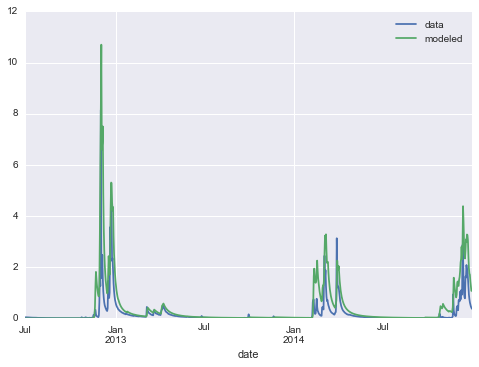

In [6]:
discharge = np.array(network_volumetric_discharges[2].volumetric_discharge/rew_config[2]['upstream_area'])
elder_df = pickle.load( open( os.path.join(parent_dir, 'calibration_data', 'elder_2010_2015.p'), 'rb'))
elder_runoff_df = elder_df['runoff'][start_date:stop_date]
elder_runoff = np.array(elder_df['runoff'][start_date:stop_date])
outflows_df = pd.DataFrame({'data':elder_runoff, 'modeled':discharge}, index = elder_runoff_df.index)
outflows_df.plot()
plt.show()